# Note segmentation RNN training

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import GRU, Bidirectional, Dropout, Input, TimeDistributed, BatchNormalization, Dense, Conv1D, Activation, UpSampling1D
from keras.models import Model
from keras.optimizers import Adam
from livelossplot import PlotLossesKeras
import IPython.display as ipd

Using TensorFlow backend.


<a href=#temp>Temporal input</a><br>
<a href=#spec>Spectral input</a>

<p id="temp"></p>

# Input: temporal data

## Loading data

In [23]:
data = pd.read_pickle("../../Data/Guitar/File_onset_data_final.pkl")

In [24]:
np.mean(data["x"].apply(lambda x: x.shape[0]))

50000.0

In [25]:
data["Riff"] = data["File"].str.split("riff").str[-1].str.split(".").str[0].str.split("_").str[0]

In [26]:
train_riffs = np.random.choice(data["Riff"].unique(), size=int(0.8*data["Riff"].unique().shape[0]), replace=False)

In [27]:
train_riffs

array(['29', '10', '21', '24', '39', '22', '25', '9', '46', '32', '47',
       '38', '3', '18', '8', '23', '44', '27', '49', '35', '31', '11',
       '28', '14', '30', '15', '19', '37', '17', '45', '34', '7', '40',
       '1', '13', '42', '20', '5'], dtype=object)

In [28]:
train_data = data[data["Riff"].isin(train_riffs)].reset_index(drop=True)
val_data = data[~data["Riff"].isin(train_riffs)].reset_index(drop=True)
train_data.shape, val_data.shape

((242, 6), (56, 6))

Reshaping data

In [29]:
length = 50000

In [30]:
X_train = np.array([[[]]])
y_train = np.array([[[]]])
for i in range(train_data.shape[0]):
    x = train_data["x"].values[i].reshape((1, length, 1))
    X_train = np.append(X_train, x)
    y = train_data["y"].values[i].reshape((1, length//10, 1))
    y_train = np.append(y_train, y)
    
X_val = np.array([[[]]])
y_val = np.array([[[]]])
for i in range(val_data.shape[0]):
    x = val_data["x"].values[i].reshape((1, length, 1))
    X_val = np.append(X_val, x)
    y = val_data["y"].values[i].reshape((1, length//10, 1))
    y_val = np.append(y_val, y)

In [31]:
X_train = X_train.reshape(train_data.shape[0], length, 1)
X_val = X_val.reshape(val_data.shape[0], length, 1)
y_train = y_train.reshape(train_data.shape[0], length//10, 1)
y_val = y_val.reshape(val_data.shape[0], length//10, 1)

In [32]:
X_train.shape, y_train.shape

((242, 50000, 1), (242, 5000, 1))

In [70]:
%run ../../Utilities/Data_generator.ipynb

In [71]:
noises = np.load("../../Data/Guitar/noises_temporal.npy", allow_pickle=True)

In [77]:
datagen = Datagen(X_train, y_train, 32, p_noise=1, noises=noises)

In [78]:
a = datagen.__getitem__(0)

In [79]:
a[0].shape

(32, 50000, 1)

In [80]:
ipd.Audio(a[0][0].reshape(50000), rate=8000)

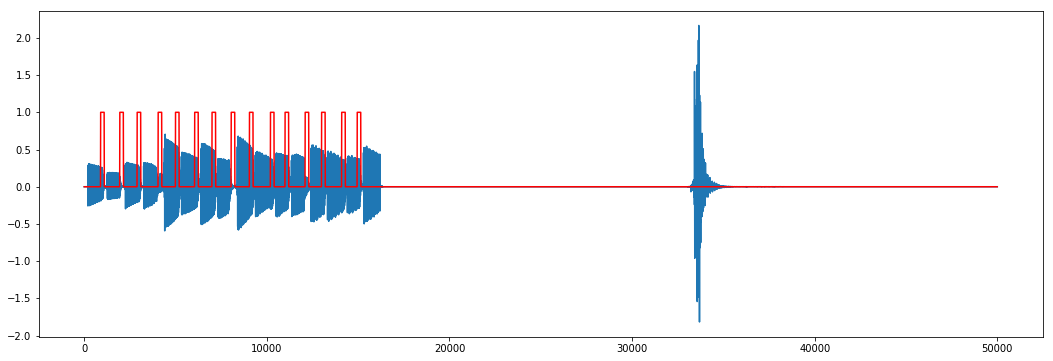

In [81]:
plt.figure(figsize=(18,6))
plt.plot(3*a[0][0].reshape(50000))
plt.plot(np.arange(0, length, 10), a[1][0], "r")

## Model building

In [94]:
def build_model(input_shape):
    X_input = Input(shape=input_shape)
    X = Conv1D(196, kernel_size=10, strides=10)(X_input)
    X = Dropout(0.2)(X)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)
    X = Bidirectional(GRU(units = 256, return_sequences = True, recurrent_dropout=0.2))(X)
    X = BatchNormalization()(X)
    X_output = TimeDistributed(Dense(1, activation = "sigmoid"))(X)
    
    return Model(inputs=X_input, outputs=X_output)

In [95]:
model = build_model((length,1))

In [96]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 50000, 1)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 5000, 196)         2156      
_________________________________________________________________
dropout_2 (Dropout)          (None, 5000, 196)         0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 5000, 196)         784       
_________________________________________________________________
activation_5 (Activation)    (None, 5000, 196)         0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 5000, 512)         695808    
_________________________________________________________________
batch_normalization_11 (Batc (None, 5000, 512)         2048      
__________

## Model training

In [97]:
import keras.backend as K
from keras.losses import binary_crossentropy

def sensitivity(y_pred, y_true):
    """
    param:
    y_pred - Predicted labels
    y_true - True labels 
    Returns:
    Specificity score
    """
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    pos_y_true = y_true
    pos_y_pred = y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    tp = K.sum(pos_y_true * pos_y_pred)
    fn = K.sum(pos_y_true * neg_y_pred)
    sensitivity = tp / (tp + fn + K.epsilon())
    return sensitivity

def precision(y_pred, y_true):
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    pos_y_true = y_true
    pos_y_pred = y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    tp = K.sum(pos_y_true * pos_y_pred)
    fn = K.sum(pos_y_true * neg_y_pred)
    precision = tp / (tp + fp + K.epsilon())
    return precision

def sensitivity_loss(y_pred, y_true):
    return 1 - sensitivity(y_pred, y_true)

def precision_loss(y_pred, y_true):
    return 1 - precision(y_pred, y_true)

def precision_sensitivity_loss(y_pred, y_true):
    return sensitivity_loss(y_pred, y_true) + 0.35 * precision_loss(y_pred, y_true)

def bce_sensitivity(y_pred, y_true):
    return sensitivity_loss(y_pred, y_true) + binary_crossentropy(y_pred, y_true)

In [98]:
model.compile(Adam(0.001), loss=precision_sensitivity_loss, metrics=["accuracy", sensitivity, precision])

In [99]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('Checkpoints/seg_gru_{val_sensitivity:.2f}.hdf5', verbose=1, monitor='val_sensitivity',
                             save_best_only=True, mode='max')

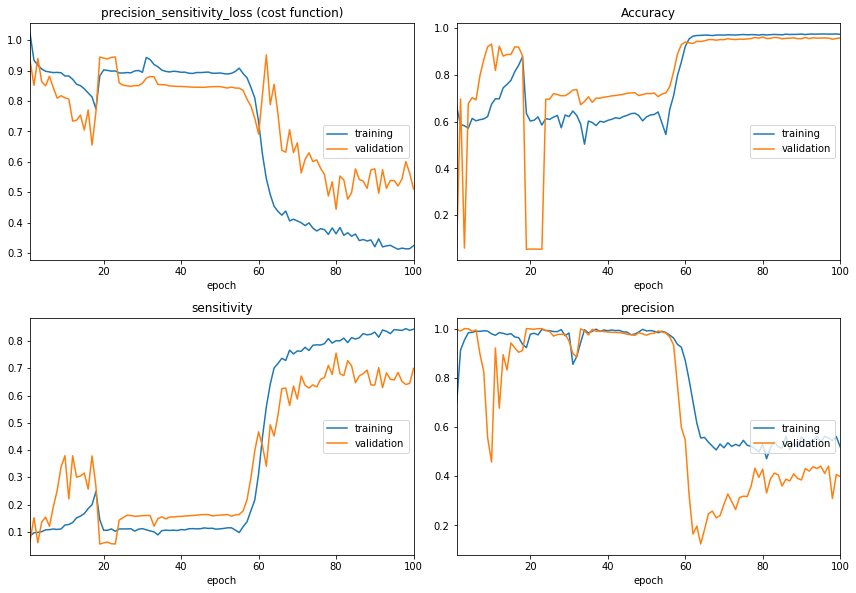

precision_sensitivity_loss (cost function):
training   (min:    0.313, max:    1.021, cur:    0.325)
validation (min:    0.444, max:    0.952, cur:    0.511)

Accuracy:
training   (min:    0.504, max:    0.974, cur:    0.972)
validation (min:    0.055, max:    0.961, cur:    0.957)

sensitivity:
training   (min:    0.085, max:    0.845, cur:    0.843)
validation (min:    0.055, max:    0.756, cur:    0.699)

precision:
training   (min:    0.471, max:    0.998, cur:    0.520)
validation (min:    0.125, max:    1.000, cur:    0.399)

Epoch 00100: val_sensitivity did not improve from 0.75550


In [101]:
model.fit_generator(datagen, epochs=100, steps_per_epoch=np.ceil(X_train.shape[0]/datagen.batch_size), 
                    validation_data=(X_val, y_val), callbacks=[PlotLossesKeras(), checkpoint])

## Model evaluation

In [52]:
model.load_weights("Checkpoints/seg_gru_0.57.hdf5")

In [53]:
pred = model.predict(X_val)

In [54]:
pred.shape

(58, 5000, 1)

In [55]:
y_pred = (pred >= 0.5).astype(int)

In [56]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val.reshape(y_val.shape[0]*y_val.shape[1]), y_pred.reshape(y_pred.shape[0]*y_pred.shape[1]))

In [57]:
cm_norm = np.vstack((cm[0,:]/cm[0,:].sum(), cm[1,:]/cm[1,:].sum()))

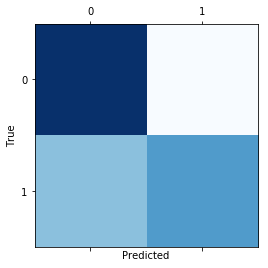

array([[0.97424995, 0.02575005],
       [0.42553059, 0.57446941]])

In [58]:
plt.matshow(cm_norm, cmap=plt.cm.Blues)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
cm_norm

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_val.reshape(y_val.shape[0]*y_val.shape[1]), y_pred.reshape(y_pred.shape[0]*y_pred.shape[1])))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97    273980
         1.0       0.57      0.57      0.57     16020

   micro avg       0.95      0.95      0.95    290000
   macro avg       0.77      0.77      0.77    290000
weighted avg       0.95      0.95      0.95    290000



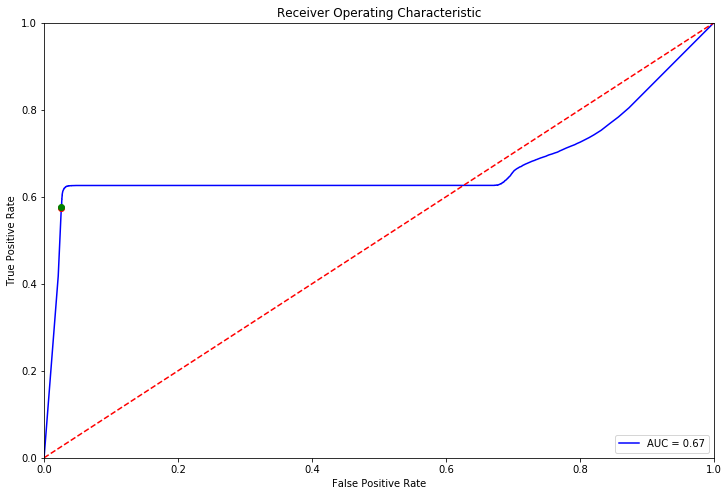

In [60]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_val.reshape(y_val.shape[0]*y_val.shape[1]), pred.reshape(pred.shape[0]*pred.shape[1]))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

thresh_0_5 = np.argmin(np.abs(threshold - 0.5))
plt.plot(fpr[thresh_0_5], tpr[thresh_0_5], "ro")
plt.show()

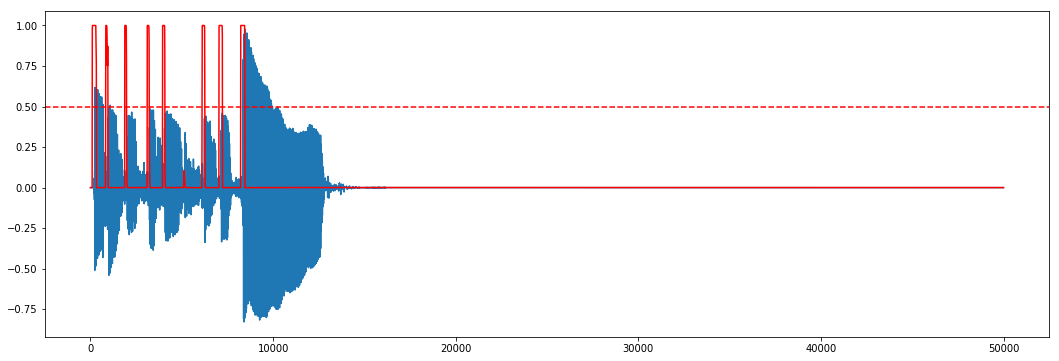

In [91]:
index = np.random.randint(0, X_val.shape[0])
plt.figure(figsize=(18,6))
plt.plot(3*X_val[index])
plt.plot(np.arange(0, length, 10), pred[index], "r")
plt.axhline(0.5, color="r", linestyle="--")

<p id="spec"></p>

# Input: spectral data

## Loading data

In [2]:
data = pd.read_pickle("../../Data/Guitar/File_onset_data_final.pkl")

In [3]:
data["Riff"] = data["File"].str.split("riff").str[-1].str.split(".").str[0].str.split("_").str[0]

In [4]:
train_riffs = np.random.choice(data["Riff"].unique(), size=int(0.8*data["Riff"].unique().shape[0]), replace=False)

In [5]:
train_data = data[data["Riff"].isin(train_riffs)].reset_index(drop=True)
val_data = data[~data["Riff"].isin(train_riffs)].reset_index(drop=True)
train_data.shape, val_data.shape

((221, 6), (77, 6))

In [6]:
chunks, freqs = train_data["xf"].sample().values[0].shape

In [7]:
length = 50000

In [8]:
X_train = np.array([[[]]])
y_train = np.array([[[]]])
for i in range(train_data.shape[0]):
    x = train_data["xf"].values[i].reshape((1, chunks, freqs))
    X_train = np.append(X_train, x)
    y = train_data["y"].values[i].reshape((1, length//10, 1))
    y_train = np.append(y_train, y)
    
X_val = np.array([[[]]])
y_val = np.array([[[]]])
for i in range(val_data.shape[0]):
    x = val_data["xf"].values[i].reshape((1, chunks, freqs))
    X_val = np.append(X_val, x)
    y = val_data["y"].values[i].reshape((1, length//10, 1))
    y_val = np.append(y_val, y)

In [9]:
X_train = X_train.reshape(train_data.shape[0], chunks, freqs)
X_val = X_val.reshape(val_data.shape[0], chunks, freqs)
y_train = y_train.reshape(train_data.shape[0], length//10, 1)
y_val = y_val.reshape(val_data.shape[0], length//10, 1)

In [10]:
X_train.shape, y_train.shape

((221, 1000, 50), (221, 5000, 1))

In [11]:
%run ../../Utilities/Data_generator.ipynb

In [12]:
noises = np.load("../../Data/Guitar/noises_spectral.npy", allow_pickle=True)

In [13]:
datagen = Datagen(X_train, y_train, 32, p_white_noise=0.75, white_noise_strength=0.2, p_cutout=0.9, n_cutout=10000, 
                  noises=noises, p_noise=0.5)
a = datagen.__getitem__(0)
a[0].shape

(32, 1000, 50)

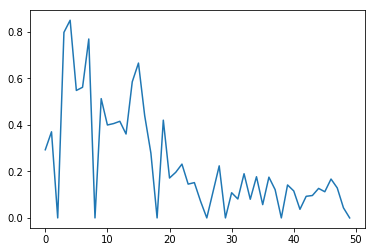

In [14]:
plt.plot(a[0][0, 100])

## Model building

In [15]:
def build_model(input_shape):
    X_input = Input(shape=input_shape)
    X = Conv1D(196, kernel_size=1, strides=1)(X_input)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)
    X = Dropout(0.5)(X)
    X = Bidirectional(GRU(units = 256, return_sequences = True, recurrent_dropout=0.5))(X)
    X = Dropout(0.5)(X)
    X = BatchNormalization()(X)
    X = UpSampling1D(5)(X)
    X_output = TimeDistributed(Dense(1, activation = "sigmoid"))(X)
    
    return Model(inputs=X_input, outputs=X_output)

In [16]:
model = build_model((chunks,freqs))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000, 50)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 196)         9996      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 196)         784       
_________________________________________________________________
activation_1 (Activation)    (None, 1000, 196)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 196)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000, 512)         695808    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000, 512)         0         
__________

## Model training

In [18]:
import keras.backend as K
from keras.losses import binary_crossentropy

def sensitivity(y_pred, y_true):
    """
    param:
    y_pred - Predicted labels
    y_true - True labels 
    Returns:
    Specificity score
    """
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    pos_y_true = y_true
    pos_y_pred = y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    tp = K.sum(pos_y_true * pos_y_pred)
    fn = K.sum(pos_y_true * neg_y_pred)
    sensitivity = tp / (tp + fn + K.epsilon())
    return sensitivity

def precision(y_pred, y_true):
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    pos_y_true = y_true
    pos_y_pred = y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    tp = K.sum(pos_y_true * pos_y_pred)
    fn = K.sum(pos_y_true * neg_y_pred)
    precision = tp / (tp + fp + K.epsilon())
    return precision

def sensitivity_loss(y_pred, y_true):
    return 1 - sensitivity(y_pred, y_true)

def precision_loss(y_pred, y_true):
    return 1 - precision(y_pred, y_true)

def precision_sensitivity_loss(y_pred, y_true):
    return 0.75 * sensitivity_loss(y_pred, y_true) + precision_loss(y_pred, y_true)

def bce_sensitivity(y_pred, y_true):
    return sensitivity_loss(y_pred, y_true) + binary_crossentropy(y_pred, y_true)

In [19]:
model.compile(Adam(0.001), loss=precision_sensitivity_loss, metrics=["accuracy", sensitivity, precision])

In [20]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('Checkpoints/seg_gru_{val_sensitivity:.2f}_{val_precision:.2f}.hdf5', 
                             verbose=1, monitor='val_sensitivity',
                             save_best_only=False, mode='max')

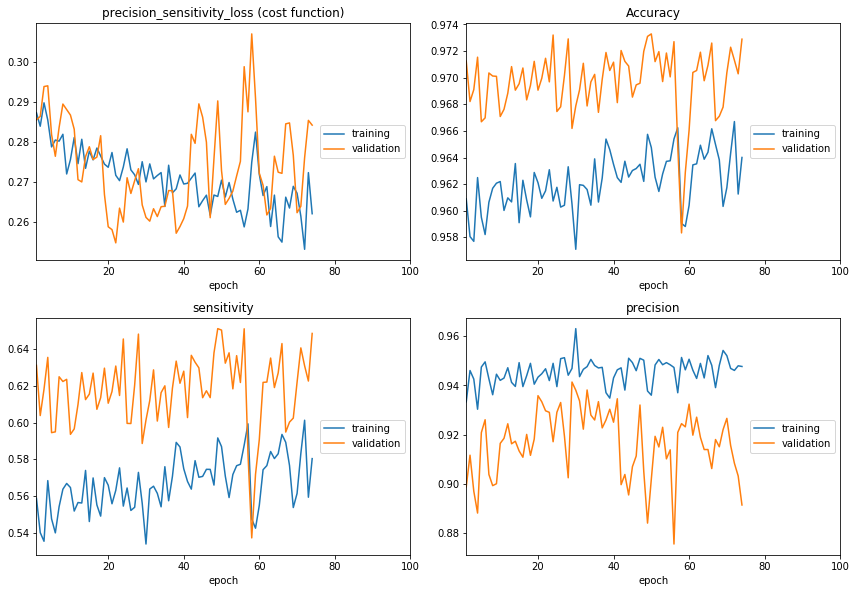

precision_sensitivity_loss (cost function):
training   (min:    0.253, max:    0.290, cur:    0.262)
validation (min:    0.255, max:    0.307, cur:    0.284)

Accuracy:
training   (min:    0.957, max:    0.967, cur:    0.964)
validation (min:    0.958, max:    0.973, cur:    0.973)

sensitivity:
training   (min:    0.534, max:    0.601, cur:    0.580)
validation (min:    0.537, max:    0.651, cur:    0.649)

precision:
training   (min:    0.930, max:    0.963, cur:    0.948)
validation (min:    0.876, max:    0.941, cur:    0.891)

Epoch 00074: saving model to Checkpoints/seg_gru_0.65_0.89.hdf5
Epoch 75/100
6/8 [=====================>........] - ETA: 8s - loss: 0.2571 - acc: 0.9663 - sensitivity: 0.5955 - precision: 0.9451 

KeyboardInterrupt: 

In [86]:
history = model.fit_generator(datagen, epochs=100, steps_per_epoch=np.ceil(X_train.shape[0]/datagen.batch_size), 
                    validation_data=(X_val, y_val), callbacks=[PlotLossesKeras(), checkpoint])

## Model evaluation

In [21]:
model.load_weights("Checkpoints/final_weights/seg_gru_v10_0.64_0.91.hdf5")

In [22]:
pred = model.predict(X_val)

In [23]:
y_pred = (pred >= 0.5).astype(int)

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val.reshape(y_val.shape[0]*y_val.shape[1]), y_pred.reshape(y_pred.shape[0]*y_pred.shape[1]))

In [25]:
cm_norm = np.vstack((cm[0,:]/cm[0,:].sum(), cm[1,:]/cm[1,:].sum()))

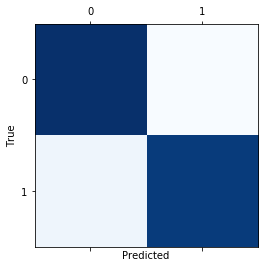

array([[0.9748097 , 0.0251903 ],
       [0.06622851, 0.93377149]])

In [26]:
plt.matshow(cm_norm, cmap=plt.cm.Blues)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
cm_norm

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_val.reshape(y_val.shape[0]*y_val.shape[1]), y_pred.reshape(y_pred.shape[0]*y_pred.shape[1])))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99    365220
         1.0       0.67      0.93      0.78     19780

   micro avg       0.97      0.97      0.97    385000
   macro avg       0.83      0.95      0.88    385000
weighted avg       0.98      0.97      0.97    385000



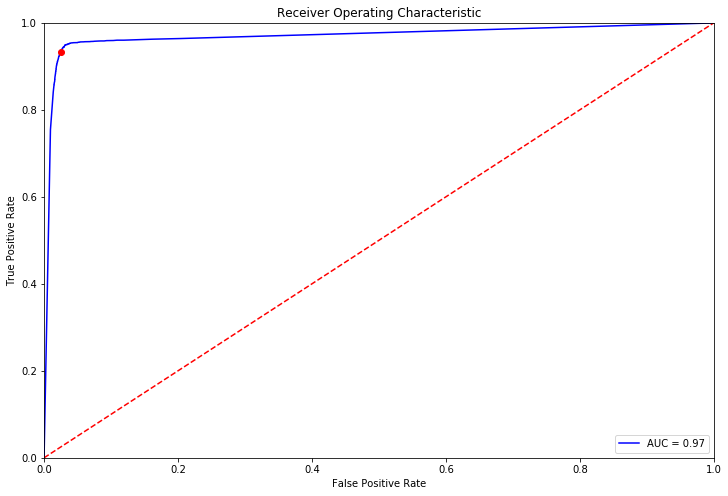

In [28]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_val.reshape(y_val.shape[0]*y_val.shape[1]), pred.reshape(pred.shape[0]*pred.shape[1]))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

thresh_0_5 = np.argmin(np.abs(threshold - 0.5))
plt.plot(fpr[thresh_0_5], tpr[thresh_0_5], "ro")
plt.show()